In [19]:
import numpy as np
import scipy.stats as sp
import pandas as pd
from sklearn.preprocessing import minmax_scale, scale

from sklearn.datasets import make_classification

def create_continuous_data(N, pos_ratio=0, k=10, cov=None, random_state=None):
    if random_state is not None: np.random.seed(random_state)
    # Group indicator
    #group = sp.binom.rvs(p=0.25, n=1, size=N)
    N_neg = int(N*(1-pos_ratio))
    N_pos = N-N_neg
    y = np.concatenate([np.zeros(N_neg), np.ones(N_pos)])
    
    mean = np.random.uniform(size=k)
    mean0 = np.random.normal(loc=mean,scale=0.1)
    mean1 = np.random.normal(loc=mean,scale=0.1)
    
    if cov is None: 
        cov0 = sp.invwishart.rvs(df=k, scale=np.eye(k)/2)
        cov1 = cov0
    elif cov == "group_cov":
        cov0 = sp.invwishart.rvs(df=k, scale=np.eye(k)/2)
        cov1 = sp.invwishart.rvs(df=k, scale=np.eye(k)/2)
    
    # Continuous variables
    X0 = sp.multivariate_normal.rvs(mean=mean0, cov= cov0, size=N_neg)
    X1 = sp.multivariate_normal.rvs(mean=mean1, cov= cov1, size=N_pos)
    
    X = np.vstack([X0,X1])
    
    return {"X":X, "y":y,"mean0":mean0,"mean1":mean1, "cov":cov}

def create_dataset(n_samples=1000, n_features=2, n_classes=3, weights=(0.01, 0.01, 0.98),
                   class_sep=0.8, n_clusters=1, random_state=0):
    return make_classification(n_samples=n_samples,
                               n_informative=2, n_redundant=0, n_repeated=0,
                               n_classes=n_classes, n_features = n_features,
                               n_clusters_per_class=n_clusters,
                               weights=list(weights),
                               class_sep=class_sep, random_state=random_state)

## Artifical Data Generation

In [20]:
from torch.utils.data import Dataset, DataLoader

class TabularDataset(Dataset):
    def __init__(self, X, y=None):
        """
        Characterizes a Dataset for PyTorch

        Parameters
        ----------

        data: pandas data frame
          The data frame object for the input data. It must
          contain all the continuous, categorical and the
          output columns to be used.

        cat_cols: List of strings
          The names of the categorical columns in the data.
          These columns will be passed through the embedding
          layers in the model. These columns must be
          label encoded beforehand.

        output_col: string
          The name of the output variable column in the data
          provided.
        """

        self.n = X.shape[0]
        self.X = X.astype(np.float32)
        self.y = y.astype(np.float32)

    def __len__(self):
        """
        Denotes the total number of samples.
        """
        return self.n

    def __getitem__(self, idx):
        """
        Generates one sample of data.
        """
        return [self.X[idx], self.y[idx],]

In [21]:
no_vars = 2
N= 100000

data = create_continuous_data(N, pos_ratio=0.1, k=no_vars, random_state=1234,
                             cov="group_cov") #, cov=np.eye(no_vars)

data["X"] = minmax_scale(data["X"])
X_majority = data["X"][data["y"]==0,:]
X_minority = data["X"][data["y"]==1,:]

y_temp = np.zeros([N,2])
y_temp[data['y']==0,0] = 1
y_temp[data['y']==1,1] = 1
data['y'] = y_temp

#mean_minority = np.mean(X_minority, axis=0)
#sd_minority = np.std(X_minority, axis=0)
#X_minority = (X_minority-mean_minority)/sd_minority

dataset = TabularDataset(data["X"], data["y"])

In [ ]:
no_vars = 2
X, y = create_dataset(n_samples=200000, n_classes=2, weights=(0.05,0.95), n_features=no_vars,
                     n_clusters=1, class_sep=0.8, random_state=123)

In [ ]:
import json
with open('../data/KDD2009.json') as f:
    data = json.load(f)

In [ ]:
X = minmax_scale(X)
X_majority = X[y==0,:]
X_minority = X[y==1,:]

dataset = TabularDataset(X_minority, y[y==1])

In [22]:
batch_size = 512
data_loader = DataLoader(dataset, batch_size = batch_size, shuffle=True)

In [23]:
from wgan.models import Generator, Discriminator
from wgan.training import Trainer

import torch
import torch.optim as optim
from torch.autograd import Variable

In [35]:
generator = Generator(latent_dim=20, lin_layer_sizes=[64,64], output_dim=no_vars, aux_dim=2)
discriminator = Discriminator(input_size=no_vars, lin_layer_sizes=[32,64,64], aux_input_size=2)

print(generator)
print(discriminator)

Generator(
  (lin_layers): ModuleList(
    (0): Linear(in_features=22, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=64, bias=True)
  )
  (output_layer): Linear(in_features=64, out_features=2, bias=True)
)
Discriminator(
  (lin_layers): ModuleList(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=64, bias=True)
  )
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)


In [36]:
# Initialize optimizers
lr_G = 1e-4
lr_D = 1e-4
betas = (.9, .99)
G_optimizer = optim.Adam(generator.parameters(), lr=lr_G, betas=betas)
D_optimizer = optim.Adam(discriminator.parameters(), lr=lr_D, betas=betas)

In [37]:
trainer = Trainer(generator, discriminator, G_optimizer, D_optimizer, print_every=1000,
                  use_cuda=torch.cuda.is_available())

In [38]:
trainer.gp_weight = 1

In [ ]:
# Train model
epochs = 100
trainer.train(data_loader, epochs,  save_training_gif=True)

## Generate new data

In [39]:
from torch import Tensor as T

In [ ]:
fake = generator(generator.sample_latent(10000), T(np.ones(10000)).unsqueeze(dim=1) ).data.numpy()
#fake = (fake + mean_minority)*sd_minority

In [ ]:
fake_majority = generator(generator.sample_latent(10000), T(np.zeros(10000)).unsqueeze(dim=1) ).data.numpy()


In [ ]:
print(np.mean(X_minority, axis=0))
print(np.mean(fake, axis=0))

In [ ]:
print(np.quantile(X_minority, q=np.arange(0,1,0.1), axis=0))
print(np.quantile(fake, q=np.arange(0,1,0.1), axis=0))

In [ ]:
print(np.cov(X_minority, rowvar=False) - np.cov(fake,rowvar=False))


## Visual test

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
i=0
j=1

plt.scatter(X_majority[:,i], X_majority[:,j], alpha=0.05, c="blue")
plt.scatter(X_minority[:,i], X_minority[:,j], alpha=0.05,c="green")
#plt.show()
plt.scatter(fake_majority[:,i], fake_majority[:,j], alpha=0.01, c="cyan")
plt.scatter(fake[:,i], fake[:,j], alpha=0.01, c="orange")
plt.show()


Epoch 1
Iteration 1
D: -0.0018687304109334946
GP: 0.9523411393165588
Gradient norm: 0.024131231009960175

Epoch 2
Iteration 1
D: -0.014100642874836922
GP: 0.3764054775238037
Gradient norm: 0.3931035101413727
G: 0.014027006924152374

Epoch 3
Iteration 1
D: 0.03099234402179718
GP: 0.10883159935474396
Gradient norm: 0.7466306686401367
G: 0.08560758829116821

Epoch 4
Iteration 1
D: 0.09003046154975891
GP: 0.13380472362041473
Gradient norm: 0.641672670841217
G: 0.3620224595069885

Epoch 5
Iteration 1
D: 0.2067471742630005
GP: 0.020881447941064835
Gradient norm: 0.8601825833320618
G: 0.4349293112754822


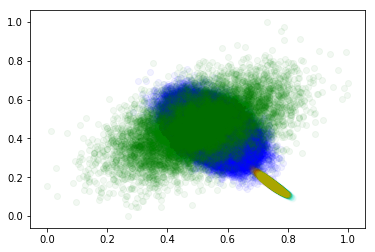


Epoch 1
Iteration 1
D: 0.2568387985229492
GP: 0.03038107603788376
Gradient norm: 0.8320919871330261
G: 0.5562804341316223

Epoch 2
Iteration 1
D: 0.22801697254180908
GP: 0.0318862646818161
Gradient norm: 0.8368030190467834
G: 0.8948769569396973

Epoch 3
Iteration 1
D: 0.13688266277313232
GP: 0.023913677781820297
Gradient norm: 0.8675084114074707
G: 1.1658940315246582

Epoch 4
Iteration 1
D: 0.05693364143371582
GP: 0.014262364245951176
Gradient norm: 0.9134950637817383
G: 1.110031008720398

Epoch 5
Iteration 1
D: -0.04132080078125
GP: 0.023022117093205452
Gradient norm: 0.9860860705375671
G: 0.7444323897361755


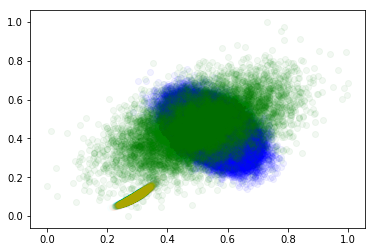


Epoch 1
Iteration 1
D: -0.16202351450920105
GP: 0.02921566739678383
Gradient norm: 1.0360689163208008
G: 0.4890376925468445

Epoch 2
Iteration 1
D: -0.31317296624183655
GP: 0.02404487319290638
Gradient norm: 1.0913498401641846
G: 0.40305018424987793

Epoch 3
Iteration 1
D: -0.36221814155578613
GP: 0.02413070574402809
Gradient norm: 1.1290465593338013
G: 0.31894445419311523

Epoch 4
Iteration 1
D: -0.27774578332901
GP: 0.01607780158519745
Gradient norm: 1.1210074424743652
G: 0.2667846083641052

Epoch 5
Iteration 1
D: -0.18663233518600464
GP: 0.00808671023696661
Gradient norm: 1.0855820178985596
G: 0.2505391538143158


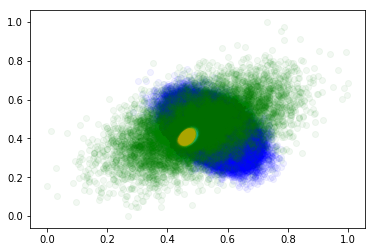


Epoch 1
Iteration 1
D: -0.11835610866546631
GP: 0.004454468842595816
Gradient norm: 1.0539801120758057
G: 0.2616085410118103

Epoch 2
Iteration 1
D: -0.05971497297286987
GP: 0.009593520313501358
Gradient norm: 1.023020625114441
G: 0.44921213388442993

Epoch 3
Iteration 1
D: -0.023243725299835205
GP: 0.02429923601448536
Gradient norm: 0.9840912818908691
G: 0.5382599830627441

Epoch 4
Iteration 1
D: -0.06686484813690186
GP: 0.030875110998749733
Gradient norm: 1.0128557682037354
G: 1.4409435987472534

Epoch 5
Iteration 1
D: -0.07243120670318604
GP: 0.01071973517537117
Gradient norm: 1.0363386869430542
G: 1.7714052200317383


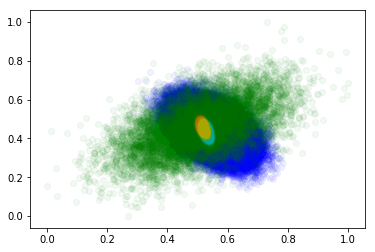


Epoch 1
Iteration 1
D: -0.04000425338745117
GP: 0.014695915393531322
Gradient norm: 1.0062124729156494
G: 1.6865333318710327

Epoch 2
Iteration 1
D: -0.06713694334030151
GP: 0.04220656305551529
Gradient norm: 0.9931050539016724
G: 1.0314804315567017

Epoch 3
Iteration 1
D: -0.036062777042388916
GP: 0.029396360740065575
Gradient norm: 0.9828412532806396
G: 0.7542099952697754

Epoch 4
Iteration 1
D: 0.00029987096786499023
GP: 0.037893202155828476
Gradient norm: 0.9473210573196411
G: 0.5452075600624084

Epoch 5
Iteration 1
D: -0.0758826732635498
GP: 0.02794049307703972
Gradient norm: 1.0024617910385132
G: 1.3466386795043945


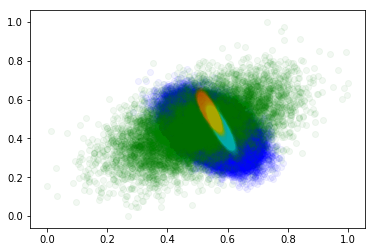


Epoch 1
Iteration 1
D: -0.04500079154968262
GP: 0.006120746023952961
Gradient norm: 1.0326950550079346
G: 1.5245692729949951

Epoch 2
Iteration 1
D: 0.014478921890258789
GP: 0.02857690304517746
Gradient norm: 0.9411908984184265
G: 1.6482536792755127

Epoch 3
Iteration 1
D: -0.08890974521636963
GP: 0.035598672926425934
Gradient norm: 1.1184805631637573
G: 0.883507490158081

Epoch 4
Iteration 1
D: -0.02207726240158081
GP: 0.019724879413843155
Gradient norm: 0.9920592904090881
G: 0.8100962042808533

Epoch 5
Iteration 1
D: 0.030181169509887695
GP: 0.0741085559129715
Gradient norm: 0.8077473640441895
G: 0.7377477288246155


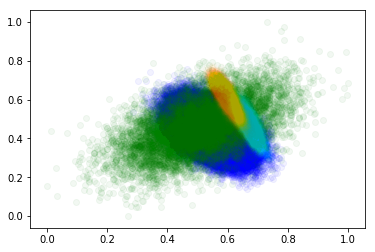


Epoch 1
Iteration 1
D: -0.011193275451660156
GP: 0.004154162015765905
Gradient norm: 0.989958643913269
G: 0.7689827680587769

Epoch 2
Iteration 1
D: -0.16731572151184082
GP: 0.020125525072216988
Gradient norm: 1.0892212390899658
G: 1.2517093420028687

Epoch 3
Iteration 1
D: -0.01743793487548828
GP: 0.004123994614928961
Gradient norm: 0.9977965354919434
G: 0.9561610221862793

Epoch 4
Iteration 1
D: -0.03326678276062012
GP: 0.07361819595098495
Gradient norm: 0.9960281252861023
G: 1.4104341268539429

Epoch 5
Iteration 1
D: -0.08412390947341919
GP: 0.008192701265215874
Gradient norm: 1.0475319623947144
G: 0.5231624841690063


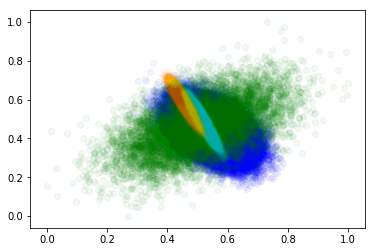


Epoch 1
Iteration 1
D: -0.058897465467453
GP: 0.012378206476569176
Gradient norm: 1.0200889110565186
G: 0.511393666267395

Epoch 2
Iteration 1
D: -0.007935762405395508
GP: 0.019918372854590416
Gradient norm: 0.9565404653549194
G: 1.3072476387023926

Epoch 3
Iteration 1
D: -0.0506134033203125
GP: 0.007356496527791023
Gradient norm: 1.0150408744812012
G: 0.7870407104492188

Epoch 4
Iteration 1
D: -0.008509427309036255
GP: 0.023660846054553986
Gradient norm: 0.983287513256073
G: 0.40995264053344727

Epoch 5
Iteration 1
D: -0.06083786487579346
GP: 0.005930323153734207
Gradient norm: 1.0256268978118896
G: 0.7706432342529297


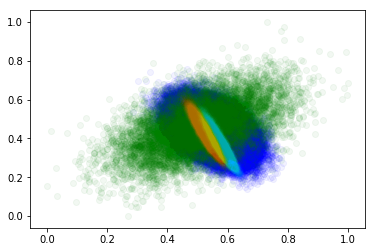


Epoch 1
Iteration 1
D: -0.012763500213623047
GP: 0.039500024169683456
Gradient norm: 0.9439939856529236
G: 1.548646092414856

Epoch 2
Iteration 1
D: -0.049247801303863525
GP: 0.01021745428442955
Gradient norm: 1.0067116022109985
G: 0.8855549097061157

Epoch 3
Iteration 1
D: -0.015096127986907959
GP: 0.03928997740149498
Gradient norm: 0.9210087656974792
G: 0.6914519667625427

Epoch 4
Iteration 1
D: -0.06284642219543457
GP: 0.006123104132711887
Gradient norm: 1.0325754880905151
G: 0.7903569936752319

Epoch 5
Iteration 1
D: 0.008761286735534668
GP: 0.0517880916595459
Gradient norm: 0.8972508907318115
G: 1.175478219985962


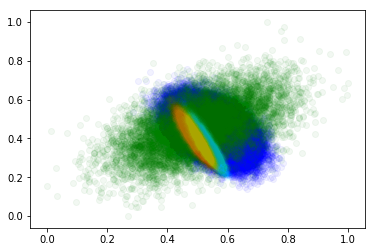


Epoch 1
Iteration 1
D: -0.09594976902008057
GP: 0.016867753118276596
Gradient norm: 1.0676343441009521
G: 1.1716036796569824

Epoch 2
Iteration 1
D: -0.010865986347198486
GP: 0.020915061235427856
Gradient norm: 0.9819474220275879
G: 0.9969370365142822

Epoch 3
Iteration 1
D: -0.10317790508270264
GP: 0.02596978098154068
Gradient norm: 1.115039348602295
G: 0.9300299286842346

Epoch 4
Iteration 1
D: -0.0071909427642822266
GP: 0.016731051728129387
Gradient norm: 0.9878423810005188
G: 0.6920502781867981

Epoch 5
Iteration 1
D: -0.06120598316192627
GP: 0.030526557937264442
Gradient norm: 0.948805570602417
G: 0.924589216709137


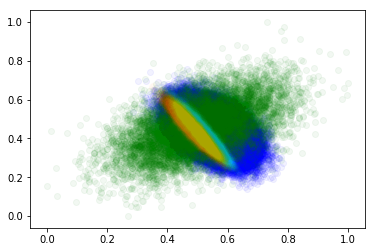


Epoch 1
Iteration 1
D: -0.03608274459838867
GP: 0.008102904073894024
Gradient norm: 1.024035930633545
G: 0.9654548764228821

Epoch 2
Iteration 1
D: 0.006352603435516357
GP: 0.06811892241239548
Gradient norm: 0.8539495468139648
G: 0.4854525625705719

Epoch 3
Iteration 1
D: -0.10411763191223145
GP: 0.03451988101005554
Gradient norm: 1.0622642040252686
G: 1.2965786457061768

Epoch 4
Iteration 1
D: -0.051943182945251465
GP: 0.008953506126999855
Gradient norm: 1.0136992931365967
G: 0.7851967215538025

Epoch 5
Iteration 1
D: 0.09930911660194397
GP: 0.012389123439788818
Gradient norm: 0.9306733012199402
G: 0.42736539244651794


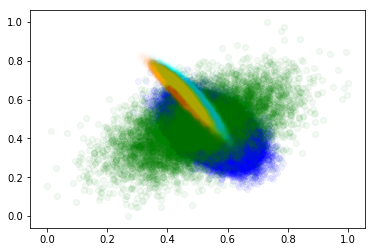


Epoch 1
Iteration 1
D: -0.21425724029541016
GP: 0.04644263908267021
Gradient norm: 1.113327980041504
G: 0.4896014332771301

Epoch 2
Iteration 1
D: -0.05594298243522644
GP: 0.006891286000609398
Gradient norm: 1.0287151336669922
G: 0.5123854875564575

Epoch 3
Iteration 1
D: 0.035690248012542725
GP: 0.02396421693265438
Gradient norm: 0.9561213254928589
G: 0.45667511224746704

Epoch 4
Iteration 1
D: -0.12667876482009888
GP: 0.011333231814205647
Gradient norm: 1.0684573650360107
G: 0.43776339292526245

Epoch 5
Iteration 1
D: -0.02499067783355713
GP: 0.008619295433163643
Gradient norm: 1.0026214122772217
G: 0.577789306640625


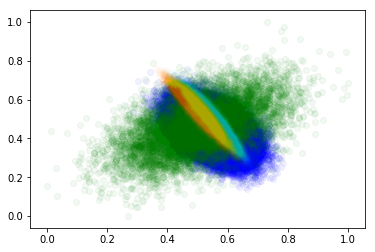


Epoch 1
Iteration 1
D: -0.05466371774673462
GP: 0.02335856854915619
Gradient norm: 0.9803588390350342
G: 0.6908608675003052

Epoch 2
Iteration 1
D: -0.030367672443389893
GP: 0.02157813124358654
Gradient norm: 0.9871152639389038
G: 0.7781769037246704

Epoch 3
Iteration 1
D: -0.0025228261947631836
GP: 0.009923760779201984
Gradient norm: 0.983018696308136
G: 0.30684107542037964

Epoch 4
Iteration 1
D: -0.061175018548965454
GP: 0.013149062171578407
Gradient norm: 1.0185918807983398
G: 0.1949235498905182

Epoch 5
Iteration 1
D: -0.02567201852798462
GP: 0.01211187057197094
Gradient norm: 0.9944025874137878
G: 0.581290602684021


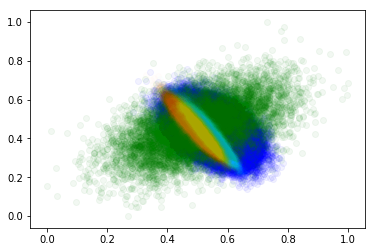


Epoch 1
Iteration 1
D: -0.028188496828079224
GP: 0.01957632042467594
Gradient norm: 0.9868215322494507
G: 0.286486953496933

Epoch 2
Iteration 1
D: -0.04275713860988617
GP: 0.02200579084455967
Gradient norm: 1.0021007061004639
G: 0.24466559290885925

Epoch 3
Iteration 1
D: -0.010134518146514893
GP: 0.029395900666713715
Gradient norm: 0.9705526232719421
G: 0.8328932523727417

Epoch 4
Iteration 1
D: -0.025923073291778564
GP: 0.027798518538475037
Gradient norm: 0.9586839079856873
G: 0.5502360463142395

Epoch 5
Iteration 1
D: -0.03777630627155304
GP: 0.010349954478442669
Gradient norm: 1.019188404083252
G: 0.2735859751701355


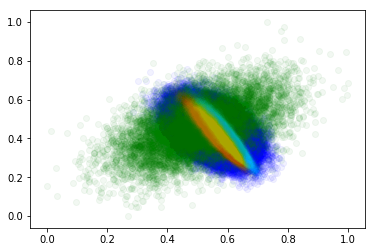


Epoch 1
Iteration 1
D: -0.0035428404808044434
GP: 0.014525122940540314
Gradient norm: 0.9829564690589905
G: 0.8404657244682312

Epoch 2
Iteration 1
D: -0.02797675132751465
GP: 0.030154014006257057
Gradient norm: 0.9882922172546387
G: 0.9666845798492432

Epoch 3
Iteration 1
D: -0.02508322149515152
GP: 0.014895979315042496
Gradient norm: 1.0069894790649414
G: 0.10112110525369644

Epoch 4
Iteration 1
D: -0.028635680675506592
GP: 0.006108130794018507
Gradient norm: 1.0123372077941895
G: 0.5627812743186951

Epoch 5
Iteration 1
D: -0.045871615409851074
GP: 0.03158022463321686
Gradient norm: 0.9996912479400635
G: 0.5046942234039307


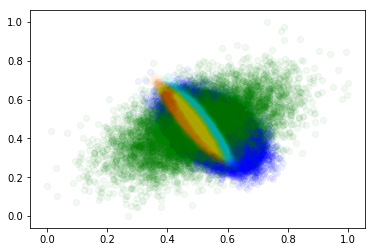


Epoch 1
Iteration 1
D: -0.019459940493106842
GP: 0.01585039310157299
Gradient norm: 0.9929203987121582
G: 0.09429630637168884

Epoch 2
Iteration 1
D: 0.006238400936126709
GP: 0.006481727585196495
Gradient norm: 0.9910774230957031
G: 0.651274561882019

Epoch 3
Iteration 1
D: -0.054435014724731445
GP: 0.013650156557559967
Gradient norm: 1.0124229192733765
G: 0.40789994597435

Epoch 4
Iteration 1
D: -0.002554565668106079
GP: 0.018353784456849098
Gradient norm: 0.9810140132904053
G: 0.0069188689813017845

Epoch 5
Iteration 1
D: -0.04380595684051514
GP: 0.0061257379129529
Gradient norm: 1.0264148712158203
G: 0.5566216111183167


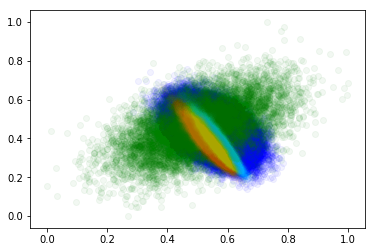


Epoch 1
Iteration 1
D: 0.003740549087524414
GP: 0.02776223234832287
Gradient norm: 0.960699200630188
G: 0.8069843053817749

Epoch 2
Iteration 1
D: -0.04869489371776581
GP: 0.005164675414562225
Gradient norm: 1.0294315814971924
G: 0.21024282276630402

Epoch 3
Iteration 1
D: -0.04314231872558594
GP: 0.011189533397555351
Gradient norm: 1.010925531387329
G: 0.18930989503860474

Epoch 4
Iteration 1
D: -0.005006909370422363
GP: 0.01774774305522442
Gradient norm: 1.0005230903625488
G: 0.838902473449707

Epoch 5
Iteration 1
D: -0.028356313705444336
GP: 0.00515281967818737
Gradient norm: 1.00446617603302
G: 0.4209766387939453


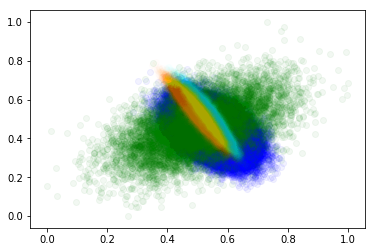


Epoch 1
Iteration 1
D: -0.04166850447654724
GP: 0.007872787304222584
Gradient norm: 1.0208024978637695
G: 0.2907842695713043

Epoch 2
Iteration 1
D: -0.018926501274108887
GP: 0.007063222583383322
Gradient norm: 0.9991405606269836
G: 0.6448975205421448

Epoch 3
Iteration 1
D: -0.01571357250213623
GP: 0.05165841802954674
Gradient norm: 0.8807206749916077
G: 0.6437230706214905

Epoch 4
Iteration 1
D: -0.054758280515670776
GP: 0.019236985594034195
Gradient norm: 1.0581305027008057
G: 0.4371181130409241

Epoch 5
Iteration 1
D: -0.0072109997272491455
GP: 0.009958267211914062
Gradient norm: 0.9798495769500732
G: 0.2940831184387207


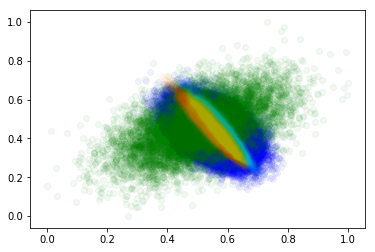


Epoch 1
Iteration 1
D: 0.008170664310455322
GP: 0.007200621999800205
Gradient norm: 1.0028445720672607
G: 0.7527351975440979

Epoch 2
Iteration 1
D: -0.05461511015892029
GP: 0.0019719384144991636
Gradient norm: 1.025422215461731
G: 0.339643269777298

Epoch 3
Iteration 1
D: -0.021680399775505066
GP: 0.008113480173051357
Gradient norm: 1.0070438385009766
G: -0.1176878809928894

Epoch 4
Iteration 1
D: -0.015737473964691162
GP: 0.0032442365773022175
Gradient norm: 1.010852575302124
G: 0.5865001082420349

Epoch 5
Iteration 1
D: -0.0757439136505127
GP: 0.006112118251621723
Gradient norm: 1.0434887409210205
G: 0.5329464077949524


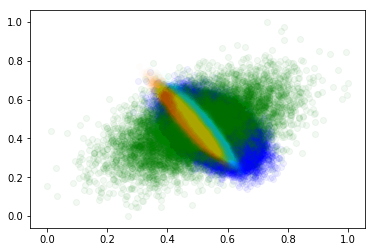


Epoch 1
Iteration 1
D: -0.0045986175537109375
GP: 0.007368771359324455
Gradient norm: 1.003361701965332
G: -0.02237885259091854

Epoch 2
Iteration 1
D: -0.05098707973957062
GP: 0.0018344648415222764
Gradient norm: 1.0298917293548584
G: 0.27342402935028076

Epoch 3
Iteration 1
D: 0.021770238876342773
GP: 0.016231589019298553
Gradient norm: 1.0005124807357788
G: 0.6683588624000549

Epoch 4
Iteration 1
D: -0.04883389174938202
GP: 0.0012193296570330858
Gradient norm: 1.0237246751785278
G: 0.18961098790168762

Epoch 5
Iteration 1
D: 0.012032106518745422
GP: 0.008334101177752018
Gradient norm: 0.9789446592330933
G: -0.24972401559352875


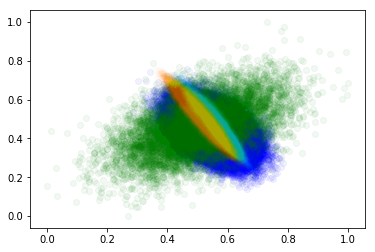

In [40]:
epochs = 5
i=0
j=1

for _ in range(20):
    trainer.train(data_loader, epochs)
    
    fake = trainer.G(trainer.G.sample_latent(10000),
                 T(np.vstack([np.zeros(10000), np.ones(10000)]).T)).data.numpy()
    fake_majority = trainer.G(trainer.G.sample_latent(10000),
                 T(np.vstack([np.ones(10000), np.zeros(10000)]).T)).data.numpy()
    plt.scatter(X_majority[:,i], X_majority[:,j], alpha=0.05, c="blue")
    plt.scatter(X_minority[:,i], X_minority[:,j], alpha=0.05,c="green")
    plt.scatter(fake_majority[:,i], fake_majority[:,j], alpha=0.01, c="cyan")
    plt.scatter(fake[:,i], fake[:,j], alpha=0.01, c="orange")
    plt.savefig(f'../img/cont_sample_tr_iter_{trainer.G.training_iterations}.png')
    plt.show()

## Predictive test

In [ ]:
X_fakereal = np.vstack([X_minority, 
                        fake])
y_fakereal = np.concatenate([np.zeros(X_minority.shape[0]), 
                        np.ones(fake.shape[0])]).flatten()

In [ ]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, brier_score_loss

clf = RandomForestClassifier(n_estimators=50, min_samples_leaf=20, n_jobs=10)
model_fakereal = clf.fit(X_fakereal, y_fakereal)

In [ ]:
pred_fakereal = model_fakereal.predict_proba(X_fakereal)[:,1]
roc_auc_score(y_fakereal, pred_fakereal)

## Model performance

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data['X'], data["y"], stratify=data['y'], test_size=0.5, random_state=123)

In [ ]:
def plot_decision_function(X, y, clf, ax):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')

In [ ]:
sample_size = X_minority.shape[0]*3
X_fake = generator(generator.sample_latent(sample_size)).data
y_fake = np.ones(shape=[sample_size])

In [ ]:
X_up = np.vstack([X_train,X_fake])
y_up = np.hstack([y_train,y_fake])

In [ ]:
clf_org = DecisionTreeClassifier(min_samples_leaf=50)
clf_fake = DecisionTreeClassifier(min_samples_leaf=50)

clf_org = clf_org.fit(X=X_train, y=y_train)
clf_fake = clf_fake.fit(X=X_up, y=y_up)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
plot_decision_function(X, y, clf_org, ax1)
plot_decision_function(np.vstack([X,X_fake]), np.hstack([y,y_fake]), clf_fake, ax2)

fig.tight_layout()

In [ ]:
pred_org = clf_org.predict_proba(X_test)[:,1]
pred_fake = clf_fake.predict_proba(X_test)[:,1]

In [ ]:
print(roc_auc_score(y_test, pred_org))
print(roc_auc_score(y_test, pred_fake))

In [ ]:
print(brier_score_loss(y_test, pred_org))
print(brier_score_loss(y_test, pred_fake))